# Oxford example

This tutorial demonstrates the `lava.lib.dl.netx` api for running Oxford network trained using `lava.lib.dl.slayer`. The training example can be found here [here](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/slayer/oxford/train.ipynb)

The task is to learn to transform a random Poisson spike train to an output spike pattern that resembles The Radcliffe Camera building of Oxford University, England. The input and output both consist of 200 neurons each and the spikes span approximately 1900ms. The input and output pair are converted from [SuperSpike](https://github.com/fzenke/pub2018superspike) (© GPL-3).

<table>
<tr>
    <td align="center"><b>Input</b></td>
    <td align="center"><b>Output</b></td>
</tr><tr>
    <td> <img src="https://github.com/lava-nc/lava-dl/raw/267e99a8fed079931d1026ca35d59d654a744bba/tutorials/lava/lib/dl/slayer/oxford/input.gif" alt="Drawing" style="height: 400px;"/> </td>
    <td> <img src="https://github.com/lava-nc/lava-dl/raw/267e99a8fed079931d1026ca35d59d654a744bba/tutorials/lava/lib/dl/slayer/oxford/output.gif" alt="Drawing" style="height: 400px"/> </td>
</tr>
</table>

![Oxford](images/oxford.PNG)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io

from utils import InputAdapter, OutputAdapter, OxfordMonitor

## Network Exchange (NetX) Libarary

The NetX api allows automatic creation of Lava process from the network specification. It is available as a part of the lava-dl library as `lava.lib.dl.netx`

In [2]:
from lava.lib.dl import netx
from lava.lib.dl import slayer

# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [3]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'oheogulch'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    from lava.proc import embedded_io as eio
    print(f'Running on {Loihi2.partition}')
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")

Running on kp_stack


## Create network block

A lava process describing the network can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as a list: `net.layers`.

In [4]:
net = netx.hdf5.Network(net_config='Trained/network.net')
print(net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  256|     |     |     |     |     |False|
|Dense     |    1|    1|  200|     |     |     |     |     |False|


In [5]:
print(f'There are {len(net)} layers in the network:')

for l in net.layers:
    print(f'{l.block:5s} : {l.name:10s}, shape : {l.shape}')

There are 2 layers in network:
Dense : Process_1 , shape : (256,)
Dense : Process_4 , shape : (200,)


## Create Spike Input/Ouptut process

Here, we will use `RingBuffer` processes in `lava.proc.io.{source/sink}` to generate spike that is sent to the network and record the spike output from the network.

There are 200 neurons and the input spikes span apprximately 2000 steps.

We will use `slayer.io` utilities to read the event data and convert them to dense spike data.

In [6]:
input = slayer.io.read_np_spikes('input.npy')
target = slayer.io.read_np_spikes('output.npy')
source = io.source.RingBuffer(data=input.to_tensor(dim=(1, 200, 2000)).squeeze())
sink = io.sink.RingBuffer(shape=net.out.shape, buffer=2000)
inp_adapter = InputAdapter(shape=net.inp.shape)
out_adapter = OutputAdapter(shape=net.out.shape)

source.s_out.connect(inp_adapter.inp)
inp_adapter.out.connect(net.inp)
net.out.connect(out_adapter.inp)
out_adapter.out.connect(sink.a_in)

## Run the network

We will run the network for 2000 steps and read the network's output.

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

In [7]:
if loihi2_is_available:
    from utils import CustomHwRunConfig
    run_config = CustomHwRunConfig()
else:
    from utils import CustomSimRunConfig
    run_config = CustomSimRunConfig()
run_condition = RunSteps(num_steps=2000)
net._log_config.level = logging.INFO
net.run(condition=run_condition, run_cfg=run_config)
output = sink.data.get()
net.stop()

Violation core_id=0 reg_name='SynMem' allocation=16128 self.cost_db.registers[reg_name]=12000
Violation core_id=1 reg_name='SynMem' allocation=16200 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=0 reg_name='SynMem' allocation=16128 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=1 reg_name='SynMem' allocation=16200 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=0 reg_name='SynMem' allocation=16128 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=1 reg_name='SynMem' allocation=16200 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=0 reg_name='SynMem' allocation=16128 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=1 reg_name='SynMem' allocation=16200 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=0 reg_name='SynMem' allocation=16128 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Vi

## Plot the results
Finally, convert output spike data into an event and plot them.

In [8]:
out_event = slayer.io.tensor_to_event(output.reshape((1,) + output.shape))
gt_event = slayer.io.read_np_spikes('ground_truth.npy')

Text(0.5, 0, 'time')

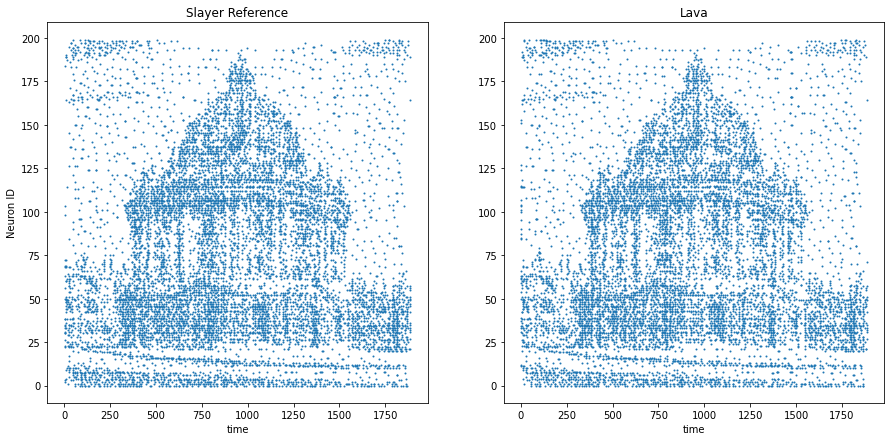

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(gt_event.t, gt_event.x, '.', markersize=2)
ax[1].plot(out_event.t, out_event.x, '.', markersize=2)
ax[0].set_title('Slayer Reference')
ax[0].set_ylabel('Neuron ID')
ax[0].set_xlabel('time')
ax[1].set_title('Lava')
ax[1].set_xlabel('time')